# Load and visualise the data

In [1]:
from keras.datasets.fashion_mnist import load_data
#load the images into memory
(trainX,trainy),(testX,testy)=load_data()
#summarize the shape of thed dataset
print('Train',trainX.shape,trainy.shape)
print('Test',testX.shape,testy.shape)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


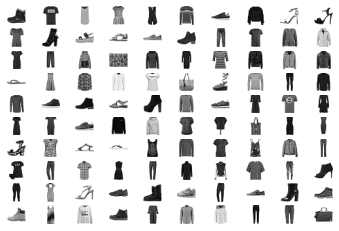

In [2]:
from matplotlib import pyplot as plt
for i in range(100):
  #define subplot
  plt.subplot(10,10,1+i)
  #turn off axis
  plt.axis('off')
  #plot raw pixels
  plt.imshow(trainX[i],cmap='gray_r')
plt.show()

# Conditional GAN model for fashion-MNIST

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [0]:
#define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1),n_classes=10):
  #label input
  in_label=Input(shape=(1,))
  #embedding for categorical input
  li=Embedding(n_classes,50)(in_label)
  #scale to image dimensions
  n_nodes=in_shape[0]*in_shape[1]
  li=Dense(n_nodes)(li)
  #reshape to additional channel
  li=Reshape((in_shape[0],in_shape[1],1))(li)
  #image_input
  in_image=Input(shape=in_shape)
  #concat label as channel
  merge=Concatenate()([in_image,li])
  #downsample
  fe=Conv2D(128,(3,3),strides=(2,2),padding='same')(merge)
  fe=LeakyReLU(alpha=0.2)(fe)
  #downsample
  fe=Conv2D(128,(3,3),strides=(2,2),padding='same')(fe)
  fe=LeakyReLU(alpha=0.2)(fe)
  #flatten feature maps
  fe=Flatten()(fe)
  #dropout
  fe=Dropout(0.4)(fe)
  #output
  out_layer=Dense(1,activation='sigmoid')(fe)
  #define model
  model=Model([in_image,in_label],out_layer)
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model



In [0]:
#define the standalone generator model
def define_generator(latent_dim,n_classes=10):
  #label input
  in_label = Input(shape=(1,))
  #embedding for categorical input
  li=Embedding(n_classes,50)(in_label)
  #linear multiplication
  n_nodes=7*7
  li=Dense(n_nodes)(li)
  #reshape to additional channel
  li=Reshape((7,7,1))(li)
  #image generator output
  in_lat=Input(shape=(latent_dim,))
  #foundation for 7X7 image
  n_nodes=128 * 7 * 7
  gen=Dense(n_nodes)(in_lat)
  gen=LeakyReLU(alpha=0.2)(gen)
  gen=Reshape((7,7,128))(gen)
  #merge image gen and label input
  merge=Concatenate()([gen,li])
  #upsample to 14 X 14
  gen=Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
  gen=LeakyReLU(alpha=0.2)(gen)
  #upsample to 28 X 28
  gen=Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
  gen=LeakyReLU(alpha=0.2)(gen)
  #ouput
  out_layer=Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
  #define model
  model=Model([in_lat,in_label],out_layer)
  return model

In [0]:
#define the combined generator and discriminator model
def define_gan(g_model,d_model):
  #make weights in discriminator not trainable
  d_model.trainable=False
  #get noise and label inputs from generator model
  gen_noise,gen_label=g_model.input
  #get image ouput from generator model
  gen_output=g_model.output
  #connect image output and label input from generator as inputs to discriminator
  gan_output=d_model([gen_output,gen_label])
  #define gan model 
  model=Model([gen_noise,gen_label],gan_output)
  #compile model
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

# Load and prepare data

In [0]:
#load fashion mnist images
def load_real_samples():
  #load dataset
  (trainX, trainy), (_, _) = load_data()
  #expand to 3D by adding channels
  X=expand_dims(trainX,axis=-1)
  #convert from ints to floats
  X=X.astype('float32')
  #scale from [0,255] to [-1,1]
  X=(X-127.5)/127.5
  return [X,trainy]

In [0]:
#select real samples
def generate_real_samples(dataset,n_samples):
  #split into images and labels
  images,labels=dataset
  #choose random instances
  ix=randint(0,images.shape[0],n_samples)
  #select images and labels
  X,labels=images[ix],labels[ix]
  #generate class labels
  y=ones((n_samples,1))
  return [X,labels],y


In [0]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim,n_samples,n_classes=10):
  #generate points in the latent space
  x_input=randn(latent_dim*n_samples)
  #reshape into a batch of inputs for the network
  z_input=x_input.reshape(n_samples,latent_dim)
  #generate labels
  labels=randint(0,n_classes,n_samples)
  return [z_input,labels]

In [0]:
#generating n fake examples,with class labels
def generate_fake_samples(generator,latent_dim,n_samples):
  #generate points in latent space
  z_input,labels_input=generate_latent_points(latent_dim,n_samples)
  #predict outputs
  images=generator.predict([z_input,labels_input])
  #create class labels
  y=zeros((n_samples,1))
  return [images,labels_input],y

# Train the generator and discriminator

In [0]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=100,n_batch=128):
  bat_per_epo=int(dataset[0].shape[0]/n_batch)
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected 'real' samples
      [X_real,labels_real],y_real=generate_real_samples(dataset,half_batch)
      #update discriminator model weights
      d_loss1,_=d_model.train_on_batch([X_real,labels_real],y_real)
      #generate 'fake examples
      [X_fake,labels],y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
      #update discriminator model weights
      d_loss2,_=d_model.train_on_batch([X_fake,labels],y_fake)
      #prepare points in latent space as input for the generator
      [z_input,labels_input]=generate_latent_points(latent_dim,n_batch)
      #create inverted labels for the fake samples
      y_gan=ones((n_batch,1))
      g_loss=gan_model.train_on_batch([z_input,labels_input],y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    #save the generator model
    g_model.save('cgan_generator.h5')

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

In [28]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Streaming output truncated to the last 5000 lines.
>90, 150/468, d1=0.688, d2=0.672 g=0.735
>90, 151/468, d1=0.698, d2=0.718 g=0.781
>90, 152/468, d1=0.662, d2=0.681 g=0.768
>90, 153/468, d1=0.681, d2=0.676 g=0.750
>90, 154/468, d1=0.725, d2=0.670 g=0.769
>90, 155/468, d1=0.669, d2=0.636 g=0.779
>90, 156/468, d1=0.728, d2=0.679 g=0.752
>90, 157/468, d1=0.681, d2=0.664 g=0.742
>90, 158/468, d1=0.696, d2=0.710 g=0.747
>90, 159/468, d1=0.672, d2=0.659 g=0.765
>90, 160/468, d1=0.669, d2=0.672 g=0.780
>90, 161/468, d1=0.684, d2=0.668 g=0.772
>90, 162/468, d1=0.697, d2=0.654 g=0.774
>90, 163/468, d1=0.647, d2=0.670 g=0.772
>90, 164/468, d1=0.670, d2=0.627 g=0.755
>90, 165/468, d1=0.707, d2=0.669 g=0.755
>90, 166/468, d1=0.670, d2=0.677 g=0.746
>90, 167/468, d1=0.700, d2=0.686 g=0.764
>90, 168/468, d1=0.693, d2=0.690 g=0.726
>90, 169/468, d1=0.663, d2=0.687 g=0.740
>90, 170/468, d1=0.686, d2=0.698 g=0.763
>90, 171/468, d1=0.677, d2=0.687 g=0.747
>90, 172/468, d1=0.670, d2=0.688 g=0.741
>90, 1

# Conditional Clothing Generation

In [0]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot as plt

In [0]:
def save_plot(examples,n):
  #scale from [-1,1] to [0,1]
  examples=(examples+1)/2.0
  #plot images
  for i in range(n*n):
    #define subplot
    plt.subplot(n,n,1+i)
    #turn off axis
    plt.axis('off')
    #plot
    plt.imshow(examples[i,:,:,0],cmap='gray_r')
  plt.show()

In [31]:
# load model
model = load_model('cgan_generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])

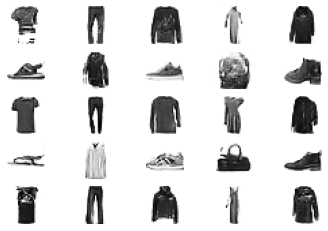

In [43]:
# generate images
X  = model.predict([latent_points, labels])
save_plot(X,5)

# Extensions


**Latent Space Size.** Experiment by varying the size of the latent space and review the impact on the quality of generated images.

**Embedding Size.** Experiment by varying the size of the class label embedding, making it smaller or larger, and review the impact on the quality of generated images.

**Alternate Architecture.** Update the model architecture to concatenate the class label elsewhere in the generator and/or discriminator model, perhaps with different dimensionality, and review the impact on the quality of generated images.

